In [4]:
import sys
sys.path.append("/home/huaqingj/MyResearch/AD_control_data/TVDN")

In [5]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import os
import scipy.stats as ss
from scipy import signal
from tqdm import tqdm
import pickle
import seaborn as sns
import numbers
%matplotlib inline

In [6]:
regionNamesRaw  ="""
ctx-lh-bankssts
ctx-lh-caudalanteriorcingulate
ctx-lh-caudalmiddlefrontal
ctx-lh-cuneus
ctx-lh-entorhinal
ctx-lh-frontalpole
ctx-lh-fusiform
ctx-lh-inferiorparietal
ctx-lh-inferiortemporal
ctx-lh-insula
ctx-lh-isthmuscingulate
ctx-lh-lateraloccipital
ctx-lh-lateralorbitofrontal
ctx-lh-lingual
ctx-lh-medialorbitofrontal
ctx-lh-middletemporal
ctx-lh-paracentral
ctx-lh-parahippocampal
ctx-lh-parsopercularis
ctx-lh-parsorbitalis
ctx-lh-parstriangularis
ctx-lh-pericalcarine
ctx-lh-postcentral
ctx-lh-posteriorcingulate
ctx-lh-precentral
ctx-lh-precuneus
ctx-lh-rostralanteriorcingulate
ctx-lh-rostralmiddlefrontal
ctx-lh-superiorfrontal
ctx-lh-superiorparietal
ctx-lh-superiortemporal
ctx-lh-supramarginal
ctx-lh-temporalpole
ctx-lh-transversetemporal
ctx-rh-bankssts
ctx-rh-caudalanteriorcingulate
ctx-rh-caudalmiddlefrontal
ctx-rh-cuneus
ctx-rh-entorhinal
ctx-rh-frontalpole
ctx-rh-fusiform
ctx-rh-inferiorparietal
ctx-rh-inferiortemporal
ctx-rh-insula
ctx-rh-isthmuscingulate
ctx-rh-lateraloccipital
ctx-rh-lateralorbitofrontal
ctx-rh-lingual
ctx-rh-medialorbitofrontal
ctx-rh-middletemporal
ctx-rh-paracentral
ctx-rh-parahippocampal
ctx-rh-parsopercularis
ctx-rh-parsorbitalis
ctx-rh-parstriangularis
ctx-rh-pericalcarine
ctx-rh-postcentral
ctx-rh-posteriorcingulate
ctx-rh-precentral
ctx-rh-precuneus
ctx-rh-rostralanteriorcingulate
ctx-rh-rostralmiddlefrontal
ctx-rh-superiorfrontal
ctx-rh-superiorparietal
ctx-rh-superiortemporal
ctx-rh-supramarginal
ctx-rh-temporalpole
ctx-rh-transversetemporal
"""
regionNames = [i.strip()[4].title() + i.strip()[6:].title() for i in regionNamesRaw.split("\n") if len(i.strip())>0]

In [7]:
os.chdir("/home/huaqingj/MyResearch/AD_control_data/TVDN")
resDir = Path("./results")
dataDir = Path("./data")

##  Results when num of cpts >=1

In [8]:
# ecpts
fil = list(resDir.glob("AD*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssAD = pickle.load(f)
fil = list(resDir.glob("Ctrl*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssCtrl = pickle.load(f)

In [9]:
# Eigvals
fil = list(resDir.glob("AD*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsAD = pickle.load(f)
fil = list(resDir.glob("Ctrl*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsCtrl = pickle.load(f)

In [10]:
eigValsAD = [eigValsAD[i] for i in range(len(eigValsAD)) if len(ecptssAD[i]) >=1]
eigValsCtrl = [eigValsCtrl[i] for i in range(len(eigValsCtrl)) if len(ecptssCtrl[i]) >=1]

In [11]:
fil = list(resDir.glob("AD*_eigVecs.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsAD = pickle.load(f)
fil = list(resDir.glob("Ctrl*_eigVecs.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsCtrl = pickle.load(f)

In [12]:
eigVecsAD = [eigVecsAD[i] for i in range(len(eigVecsAD)) if len(ecptssAD[i]) >=1]
eigVecsCtrl = [eigVecsCtrl[i] for i in range(len(eigVecsCtrl)) if len(ecptssCtrl[i]) >=1]

In [13]:
ecptssCtrl = [ i for i in ecptssCtrl if len(i)>=1]
ecptssAD = [ i for i in ecptssAD if len(i)>=1]

In [14]:
# Dwell times in second
freq = 120
dwellsAD = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssAD]
dwellsCtrl = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssCtrl]

In [15]:
import pandas as pd
def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den

fcR = pd.read_csv('./DK_dic68.csv').set_index('Unnamed: 0')
rowNames = list(fcR.index)
colNames = np.array(fcR.columns)

fcRarr = np.array(fcR)

# minmax 
fcRarrMM = np.zeros_like(fcRarr)
for i, fcRar in enumerate(fcRarr):
    lh = minmax(fcRar[:34])
    rh = minmax(fcRar[34:])
    fcRarrMM[i, :34] = lh
    fcRarrMM[i, 34:] = rh

**List of features** 

- Num of ecpts

- The mean dwell time (in second)

- Eigval with largest mode for the segment with the maximal dwell time

- EigVecs weighted by the eigvals for the segment with the maximal dwell time


In [16]:
ecptss = ecptssAD
dwells = dwellsAD
eigVals = eigValsAD
eigVecs = eigVecsAD

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.ncpts = len(ecptss[i])
    fs.meanDwell = np.mean(dwell)
    fs.maxDwell = np.max(dwell)
    fs.minDwell = np.min(dwell)
    
    eigVal = eigVals[i]
    
    idx = np.argmax(dwell)
    idx2 = np.where((-dwell).argsort().argsort()==1)[0][0]
    
    maxEigVal = eigVal[idx]
    fs.maxEigVal = maxEigVal[np.argmax(np.abs(maxEigVal))]
    fs.maxEigValMode = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))])
    fs.maxEigValReal = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].real)
    fs.maxEigValImag = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].imag)
    
    
    tmp = maxEigVal.copy()
    tmp[np.abs(maxEigVal) == np.max(np.abs(maxEigVal))] = 0
    fs.max2EigVal = tmp[np.argmax(np.abs(tmp))]
    fs.max2EigValMode = np.abs(tmp[np.argmax(np.abs(tmp))])
    fs.max2EigValReal = np.abs(tmp[np.argmax(np.abs(tmp))].real)
    fs.max2EigValImag = np.abs(tmp[np.argmax(np.abs(tmp))].imag)
    
    fs.maxwU = np.abs(np.matmul(eigVecs[i], maxEigVal))
    fs.maxwUnorm = np.linalg.norm(fs.maxwU)
    maxwUMM = np.zeros_like(fs.maxwU)
    maxwUMM[:34] = minmax(fs.maxwU[:34])
    maxwUMM[34:] = minmax(fs.maxwU[34:])
    fs.maxwUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxwUMM)[0])
        
    fs.maxwU2 = np.abs(np.matmul(eigVecs[i], eigVal[idx2]))
    fs.maxwU2norm = np.linalg.norm(fs.maxwU2)
    
    fs.maxU = eigVecs[i][:, np.argmax(np.abs(maxEigVal))]
    fs.maxUnorm = np.linalg.norm(fs.maxU)
    fs.maxUMode = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))])
    fs.maxUReal = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].real)
    fs.maxUImag = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].imag)
    maxUMM = np.zeros_like(fs.maxUMode)
    maxUMM[:34] = minmax(fs.maxUMode[:34])
    maxUMM[34:] = minmax(fs.maxUMode[34:])
    fs.maxUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxUMM)[0])
    
    fs.r  = len(maxEigVal)
    
    fsAll.append(fs)
    
fsAD = fsAll    

In [17]:
ecptss = ecptssCtrl
dwells = dwellsCtrl
eigVals = eigValsCtrl
eigVecs = eigVecsCtrl

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.ncpts = len(ecptss[i])
    fs.meanDwell = np.mean(dwell)
    fs.maxDwell = np.max(dwell)
    fs.minDwell = np.min(dwell)
    
    eigVal = eigVals[i]
    
    idx = np.argmax(dwell)
    idx2 = np.where((-dwell).argsort().argsort()==1)[0][0]
    
    maxEigVal = eigVal[idx]
    fs.maxEigVal = maxEigVal[np.argmax(np.abs(maxEigVal))]
    fs.maxEigValMode = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))])
    fs.maxEigValReal = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].real)
    fs.maxEigValImag = np.abs(maxEigVal[np.argmax(np.abs(maxEigVal))].imag)
    
    
    tmp = maxEigVal.copy()
    tmp[np.abs(maxEigVal) == np.max(np.abs(maxEigVal))] = 0
    fs.max2EigVal = tmp[np.argmax(np.abs(tmp))]
    fs.max2EigValMode = np.abs(tmp[np.argmax(np.abs(tmp))])
    fs.max2EigValReal = np.abs(tmp[np.argmax(np.abs(tmp))].real)
    fs.max2EigValImag = np.abs(tmp[np.argmax(np.abs(tmp))].imag)
    
    fs.maxwU = np.abs(np.matmul(eigVecs[i], maxEigVal))
    fs.maxwUnorm = np.linalg.norm(fs.maxwU)
    maxwUMM = np.zeros_like(fs.maxwU)
    maxwUMM[:34] = minmax(fs.maxwU[:34])
    maxwUMM[34:] = minmax(fs.maxwU[34:])
    fs.maxwUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxwUMM)[0])
        
    fs.maxwU2 = np.abs(np.matmul(eigVecs[i], eigVal[idx2]))
    fs.maxwU2norm = np.linalg.norm(fs.maxwU2)
    
    fs.maxU = eigVecs[i][:, np.argmax(np.abs(maxEigVal))]
    fs.maxUnorm = np.linalg.norm(fs.maxU)
    fs.maxUMode = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))])
    fs.maxUReal = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].real)
    fs.maxUImag = np.abs(eigVecs[i][:, np.argmax(np.abs(maxEigVal))].imag)
    maxUMM = np.zeros_like(fs.maxUMode)
    maxUMM[:34] = minmax(fs.maxUMode[:34])
    maxUMM[34:] = minmax(fs.maxUMode[34:])
    fs.maxUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxUMM)[0])
    
    fs.r  = len(maxEigVal)
    
    fsAll.append(fs)
    
fsCtrl = fsAll    

In [18]:
Ys = np.concatenate([np.ones(len(fsAD)), np.zeros(len(fsCtrl))])
#fsName = ["r", "maxwU"]
fsName = ["r", "ncpts", "maxwU", "maxwU2"]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)

In [19]:
stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

In [22]:
Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4]
aucCs = []
for C in Cs:
    eProbs = []
    loo = LeaveOneOut()
    for trIdxs, testIdxs in loo.split(stdXs):
        clf = LogisticRegression(penalty="l1", random_state=0, C=C)
        clf.fit(stdXs[trIdxs, :], Ys[trIdxs])
        eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
    eProbs = np.array(eProbs).squeeze()
    auc = roc_auc_score(Ys, eProbs[:, 1])
    fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
    aucCs.append(auc)

Text(0, 0.5, 'AUC')

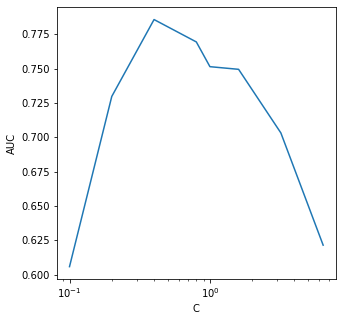

In [23]:
plt.figure(figsize=[5, 5])
plt.plot(Cs, aucCs)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("AUC")

In [24]:
optC = Cs[np.argmax(aucCs)]
eProbs = []
loo = LeaveOneOut()
parass = []
for trIdxs, testIdxs in loo.split(stdXs):
    #clf = GBC(n_estimators=50, random_state=0, max_depth=2, learning_rate=0.1)
    clf = LogisticRegression(penalty="l1", random_state=0, C=optC)
    clf.fit(stdXs[trIdxs, :], Ys[trIdxs])
    paras = clf.coef_.reshape(-1)
    parass.append(paras)
    eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
eProbs = np.array(eProbs).squeeze()
auc = roc_auc_score(Ys, eProbs[:, 1])
fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
parass = np.array(parass)
print(auc)

0.7857142857142858


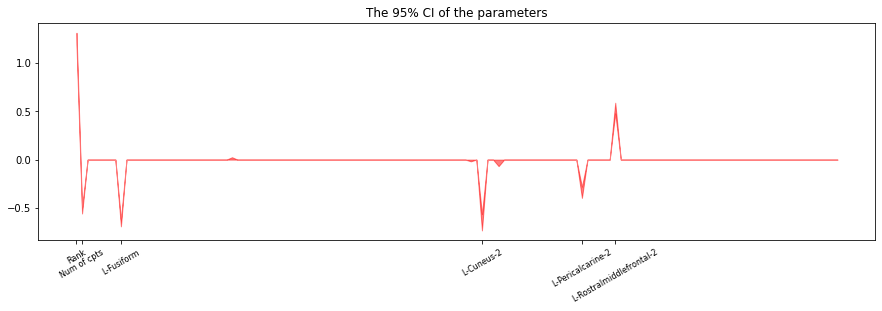

In [25]:
lows, ups = np.quantile(parass[:, :], [0.025, 0.975], axis=0)
kpidx = np.bitwise_and(lows !=0,  ups != 0)
kpidxId = np.where(kpidx)[0]

xlabs = np.concatenate([["Rank", "Num of cpts"], regionNames, [name + "-2" for name in regionNames]])
plt.figure(figsize=[15, 4])
plt.fill_between(list(range(len(lows))), lows, ups, color="red", alpha=.5)
plt.title("The 95% CI of the parameters")
_ = plt.xticks(kpidxId, xlabs[kpidxId], rotation=30, fontsize=8)
plt.savefig("./plots/lassoSelM1.jpg", bbox_inches='tight')

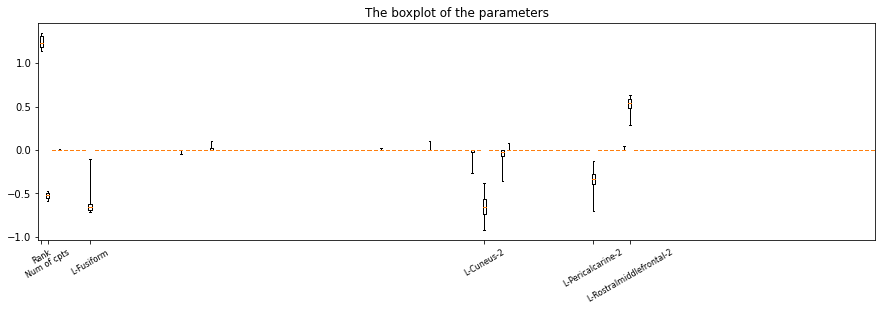

In [26]:
import matplotlib.cbook as cbook
fig, ax = plt.subplots(1, 1, figsize=[15, 4])
stats = []
for idx, nam in enumerate(xlabs):
    stats.append(cbook.boxplot_stats(parass[:, idx], labels=[nam])[0])
    stats[idx]["q1"], stats[idx]["q3"] = np.percentile(parass[:, idx], [2.5, 97.5])
    stats[idx]["whishi"], stats[idx]["whislo"] = np.max(parass[:, idx]), np.min(parass[:, idx])
    stats[idx]["med"] = stats[idx]["mean"]
ax.bxp(stats, positions=range(len(lows)), showfliers=False)    
plt.title("The boxplot of the parameters")
_ = plt.xticks(kpidxId, xlabs[kpidxId], rotation=30, fontsize=8)
plt.savefig("./plots/lassoSelM1.jpg", bbox_inches='tight')

In [27]:
import statsmodels.api as sm
stdXsLasso = stdXs[:, kpidxId]
md = sm.Logit(Ys, stdXsLasso)
mdres = md.fit()
print(mdres.summary())

Optimization terminated successfully.
         Current function value: 0.471812
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  137
Model:                          Logit   Df Residuals:                      131
Method:                           MLE   Df Model:                            5
Date:                Wed, 26 Jan 2022   Pseudo R-squ.:                  0.3161
Time:                        10:27:07   Log-Likelihood:                -64.638
converged:                       True   LL-Null:                       -94.519
Covariance Type:            nonrobust   LLR p-value:                 1.361e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.6186      0.631      4.150      0.000       1.382       3.855
x2            -0.8871      0.

In [28]:
nobs = stdXs.shape[0]
Aucss = []
for j in range(1000):
    testIdx = np.random.choice(nobs, int(nobs/5), False)
    trainIdx = np.delete(np.arange(nobs), testIdx)
    clf = LogisticRegression(penalty="l1", random_state=0, C=optC)
    clf.fit(stdXs[trainIdx], Ys[trainIdx])
    curEprobs = clf.predict_proba(stdXs[testIdx, :])
    curAuc = roc_auc_score(Ys[testIdx], curEprobs[:, 1])
    Aucss.append(curAuc)
mAUC = np.mean(Aucss)
stdAUC = np.std(Aucss)
print(f"The mean of AUC under 1000 repetitions is {mAUC:.3f} and the standard deviation is {stdAUC:.3f}.")

The mean of AUC under 1000 repetitions is 0.765 and the standard deviation is 0.099.


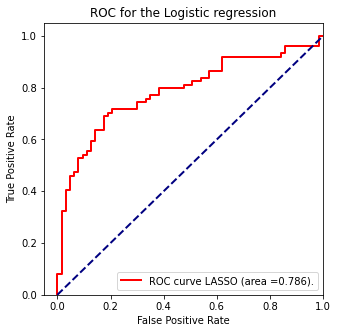

In [29]:
plt.figure(figsize=[5, 5])
plt.plot(fpr, tpr, label=f"ROC curve LASSO (area ={auc:.3f}).", lw=2, color="red")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for the Logistic regression")
plt.legend(loc="lower right")
plt.savefig("./plots/rocM1.jpg", bbox_inches='tight')

In [30]:
from sklearn.metrics import f1_score

0.7517730496453902

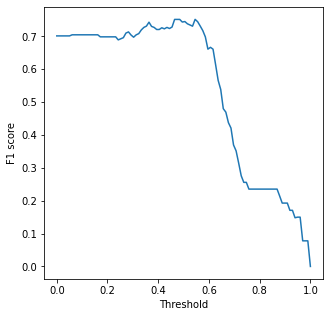

In [31]:
thres = np.linspace(0, 1, 100)
f1s = []
for thre in thres:
    f1s.append(f1_score(Ys, eProbs[:, 1]>thre))
    
plt.figure(figsize=[5, 5])
plt.plot(thres, f1s)
plt.xlabel("Threshold")
plt.ylabel("F1 score")

optThre = thres[np.argmax(f1s)]
#optThre = 0.5
f1_score(Ys, eProbs[:, 1]>optThre)

In [33]:
fsNameSet = [["maxwU", "maxwU2"],  ["r", "maxwU", "maxwU2"], 
             ["ncpts", "maxwU", "maxwU2"], ["r", "ncpts", "maxwU", "maxwU2"]]
for fsName in fsNameSet:
    Ys = np.concatenate([np.ones(len(fsAD)), np.zeros(len(fsCtrl))])
    XsAD = []
    XsCtrl = []
    for fName in fsName:
        if isinstance(fsAD[0][fName], numbers.Number):
            cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
            cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
        else:
            cfAD = np.array([fs[fName] for fs in fsAD])
            cfCtrl = np.array([fs[fName] for fs in fsCtrl])
        
        XsAD.append(cfAD)
        XsCtrl.append(cfCtrl)
    XsAD = np.concatenate(XsAD, axis=1)
    XsCtrl = np.concatenate(XsCtrl, axis=1)
    Xs = np.concatenate([XsAD, XsCtrl], axis=0)
    stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)
    
    Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4]
    aucCs = []
    for C in Cs:
        eProbs = []
        loo = LeaveOneOut()
        for trIdxs, testIdxs in loo.split(stdXs):
            clf = LogisticRegression(penalty="l1", random_state=0, C=C)
            clf.fit(stdXs[trIdxs, :], Ys[trIdxs])
            eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
        eProbs = np.array(eProbs).squeeze()
        auc = roc_auc_score(Ys, eProbs[:, 1])
        fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
        aucCs.append(auc)
        
    optC = Cs[np.argmax(aucCs)]
    eProbs = []
    loo = LeaveOneOut()
    parass = []
    for trIdxs, testIdxs in loo.split(stdXs):
        clf = LogisticRegression(penalty="l1", random_state=0, C=optC)
        clf.fit(stdXs[trIdxs, :], Ys[trIdxs])
        paras = np.concatenate([clf.intercept_, clf.coef_.reshape(-1)])
        parass.append(paras)
        eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
    eProbs = np.array(eProbs).squeeze()
    auc = roc_auc_score(Ys, eProbs[:, 1])
    fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
    parass = np.array(parass)
    
    nobs = stdXs.shape[0]
    Aucss = []
    for j in range(1000):
        testIdx = np.random.choice(nobs, int(nobs/5), False)
        trainIdx = np.delete(np.arange(nobs), testIdx)
        clf = LogisticRegression(penalty="l1", random_state=0, C=optC)
        clf.fit(stdXs[trainIdx], Ys[trainIdx])
        curEprobs = clf.predict_proba(stdXs[testIdx, :])
        curAuc = roc_auc_score(Ys[testIdx], curEprobs[:, 1])
        Aucss.append(curAuc)
    mAUC = np.mean(Aucss)
    stdAUC = np.std(Aucss)
    print(f"Features are {fsName}.")
    print(f"The AUC under optimal C is {auc:.3f}.")
    print(f"The mean of AUC under 1000 repetitions is {mAUC:.3f} and the standard deviation is {stdAUC:.3f}.")
    print("-"*100)

Features are ['maxwU', 'maxwU2'].
The AUC under optimal C is 0.734.
The mean of AUC under 1000 repetitions is 0.708 and the standard deviation is 0.098.
----------------------------------------------------------------------------------------------------
Features are ['r', 'maxwU', 'maxwU2'].
The AUC under optimal C is 0.720.
The mean of AUC under 1000 repetitions is 0.727 and the standard deviation is 0.100.
----------------------------------------------------------------------------------------------------
Features are ['ncpts', 'maxwU', 'maxwU2'].
The AUC under optimal C is 0.746.
The mean of AUC under 1000 repetitions is 0.724 and the standard deviation is 0.092.
----------------------------------------------------------------------------------------------------
Features are ['r', 'ncpts', 'maxwU', 'maxwU2'].
The AUC under optimal C is 0.786.
The mean of AUC under 1000 repetitions is 0.766 and the standard deviation is 0.091.
---------------------------------------------------------

In [29]:
def U2BrainVec(wU):
    emVec = np.zeros_like(DKtmplate, dtype=np.float64)
    for idx in range(1, 69):
        emVec[DKtmplate==idx] = wU[idx-1]
    return emVec

def reorderU(wU):
    wUreorder = np.zeros_like(wU, dtype=np.float64)
    wUreorder[0::2] = wU[:34]
    wUreorder[1::2] = wU[34:]
    return wUreorder

In [30]:
with open("./meg_data/BNVtemplate_DK68.txt", "r") as tf:
    DKtmplateRaw = tf.readlines()
DKtmplate = np.array([int(x.strip()) for x in DKtmplateRaw])

## Results when assuming no cpts

In [ ]:
eigVecss0 = []
eigValss0 = []
ps = list(resDir.glob("Ctrl*04_decimate5.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
for fil in tqdm(sortedPs):
    with open(fil, "rb") as f:
        det = pickle.load(f)
    det.UpdateEcpts(0)
    det.GetFeatures()
    eigVecss0.append(det.curEigVecs)
    eigValss0.append(det.curEigVals[0])
filNameVecs = f"Ctrl_data_lamb{det.paras.lamb:.1E}_eigVecs0.pkl"
filNameVals = f"Ctrl_data_lamb{det.paras.lamb:.1E}_eigVals0.pkl"
with open(resDir/filNameVecs, "wb") as f:
    pickle.dump(eigVecss0, f)
with open(resDir/filNameVals, "wb") as f:
    pickle.dump(eigValss0, f)

In [ ]:
eigVecss0 = []
eigValss0 = []
ps = list(resDir.glob("AD*04_decimate5.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
for fil in tqdm(sortedPs):
    with open(fil, "rb") as f:
        det = pickle.load(f)
    det.UpdateEcpts(0)
    det.GetFeatures()
    eigVecss0.append(det.curEigVecs)
    eigValss0.append(det.curEigVals[0])
filNameVecs = f"AD_data_lamb{det.paras.lamb:.1E}_eigVecs0.pkl"
filNameVals = f"AD_data_lamb{det.paras.lamb:.1E}_eigVals0.pkl"
with open(resDir/filNameVecs, "wb") as f:
    pickle.dump(eigVecss0, f)
with open(resDir/filNameVals, "wb") as f:
    pickle.dump(eigValss0, f)

In [38]:
# Eigvals
fil = list(resDir.glob("AD*_eigVals0.pkl"))[0]
with open(fil, "rb") as f:
    eigVals0AD = pickle.load(f)
fil = list(resDir.glob("Ctrl*_eigVals0.pkl"))[0]
with open(fil, "rb") as f:
    eigVals0Ctrl = pickle.load(f)
    
    
fil = list(resDir.glob("AD*_eigVecs0.pkl"))[0]
with open(fil, "rb") as f:
    eigVecs0AD = pickle.load(f)
fil = list(resDir.glob("Ctrl*_eigVecs0.pkl"))[0]
with open(fil, "rb") as f:
    eigVecs0Ctrl = pickle.load(f)

In [39]:
eigVals0 = eigVals0AD
eigVecs0 = eigVecs0AD

fs0All = []
for i in range(len(eigVals0)):
    fs = edict()
    
    eigVal = eigVals0[i]
    
    fs.maxEigVal = eigVal[np.argmax(np.abs(eigVal))]
    fs.maxEigValMode = np.abs(eigVal[np.argmax(np.abs(eigVal))])
    fs.maxEigValReal = np.abs(eigVal[np.argmax(np.abs(eigVal))].real)
    fs.maxEigValImag = np.abs(eigVal[np.argmax(np.abs(eigVal))].imag)
    
    
    tmp = eigVal.copy()
    tmp[np.abs(eigVal) == np.max(np.abs(eigVal))] = 0
    fs.max2EigVal = tmp[np.argmax(np.abs(tmp))]
    fs.max2EigValMode = np.abs(tmp[np.argmax(np.abs(tmp))])
    fs.max2EigValReal = np.abs(tmp[np.argmax(np.abs(tmp))].real)
    fs.max2EigValImag = np.abs(tmp[np.argmax(np.abs(tmp))].imag)
    
    fs.maxwU = np.abs(np.matmul(eigVecs0[i], eigVal))
    fs.maxwUnorm = np.linalg.norm(fs.maxwU)
    maxwUMM = np.zeros_like(fs.maxwU)
    maxwUMM[:34] = minmax(fs.maxwU[:34])
    maxwUMM[34:] = minmax(fs.maxwU[34:])
    fs.maxwUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxwUMM)[0])
        
    
    fs.maxU = eigVecs0[i][:, np.argmax(np.abs(eigVal))]
    fs.maxUnorm = np.linalg.norm(fs.maxU)
    fs.maxUMode = np.abs(eigVecs0[i][:, np.argmax(np.abs(eigVal))])
    fs.maxUReal = np.abs(eigVecs0[i][:, np.argmax(np.abs(eigVal))].real)
    fs.maxUImag = np.abs(eigVecs0[i][:, np.argmax(np.abs(eigVal))].imag)
    maxUMM = np.zeros_like(fs.maxUMode)
    maxUMM[:34] = minmax(fs.maxUMode[:34])
    maxUMM[34:] = minmax(fs.maxUMode[34:])
    fs.maxUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxUMM)[0])
    
    fs.r  = len(eigVal)
    
    fs0All.append(fs)
    
fs0AD = fs0All    

In [40]:
eigVals0 = eigVals0Ctrl
eigVecs0 = eigVecs0Ctrl

fs0All = []
for i in range(len(eigVals0)):
    fs = edict()
    
    eigVal = eigVals0[i]
    
    fs.maxEigVal = eigVal[np.argmax(np.abs(eigVal))]
    fs.maxEigValMode = np.abs(eigVal[np.argmax(np.abs(eigVal))])
    fs.maxEigValReal = np.abs(eigVal[np.argmax(np.abs(eigVal))].real)
    fs.maxEigValImag = np.abs(eigVal[np.argmax(np.abs(eigVal))].imag)
    
    
    tmp = eigVal.copy()
    tmp[np.abs(eigVal) == np.max(np.abs(eigVal))] = 0
    fs.max2EigVal = tmp[np.argmax(np.abs(tmp))]
    fs.max2EigValMode = np.abs(tmp[np.argmax(np.abs(tmp))])
    fs.max2EigValReal = np.abs(tmp[np.argmax(np.abs(tmp))].real)
    fs.max2EigValImag = np.abs(tmp[np.argmax(np.abs(tmp))].imag)
    
    fs.maxwU = np.abs(np.matmul(eigVecs0[i], eigVal))
    fs.maxwUnorm = np.linalg.norm(fs.maxwU)
    maxwUMM = np.zeros_like(fs.maxwU)
    maxwUMM[:34] = minmax(fs.maxwU[:34])
    maxwUMM[34:] = minmax(fs.maxwU[34:])
    fs.maxwUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxwUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxwUMM)[0])
        
    
    fs.maxU = eigVecs0[i][:, np.argmax(np.abs(eigVal))]
    fs.maxUnorm = np.linalg.norm(fs.maxU)
    fs.maxUMode = np.abs(eigVecs0[i][:, np.argmax(np.abs(eigVal))])
    fs.maxUReal = np.abs(eigVecs0[i][:, np.argmax(np.abs(eigVal))].real)
    fs.maxUImag = np.abs(eigVecs0[i][:, np.argmax(np.abs(eigVal))].imag)
    maxUMM = np.zeros_like(fs.maxUMode)
    maxUMM[:34] = minmax(fs.maxUMode[:34])
    maxUMM[34:] = minmax(fs.maxUMode[34:])
    fs.maxUcorrs = []
    for ix in range(fcRarrMM.shape[0]):
        fcRarrMMcur = fcRarrMM[ix, :]
        fs.maxUcorrs.append(ss.pearsonr(fcRarrMM[ix, :], maxUMM)[0])
    
    fs.r  = len(eigVal)
    
    fs0All.append(fs)
    
fs0Ctrl = fs0All    

In [41]:
len(fs0AD), len(fs0Ctrl)

(88, 70)

In [42]:
fsNameSet = [["r"], ["maxwU"], ["maxUMode"],
             ["r", "maxwU"], ["r", "maxUMode"], 
             ["r", "maxUMode", "maxwU"]]
for fsName in fsNameSet:
    Ys = np.concatenate([np.ones(len(fs0AD)), np.zeros(len(fs0Ctrl))])
    XsAD = []
    XsCtrl = []
    for fName in fsName:
        if isinstance(fs0AD[0][fName], numbers.Number):
            cfAD = np.array([fs[fName] for fs in fs0AD]).reshape(-1, 1)
            cfCtrl = np.array([fs[fName] for fs in fs0Ctrl]).reshape(-1, 1)
        else:
            cfAD = np.array([fs[fName] for fs in fs0AD])
            cfCtrl = np.array([fs[fName] for fs in fs0Ctrl])
        
        XsAD.append(cfAD)
        XsCtrl.append(cfCtrl)
    XsAD = np.concatenate(XsAD, axis=1)
    XsCtrl = np.concatenate(XsCtrl, axis=1)
    Xs = np.concatenate([XsAD, XsCtrl], axis=0)
    stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)
    
    Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4]
    aucCs = []
    for C in Cs:
        eProbs = []
        loo = LeaveOneOut()
        for trIdxs, testIdxs in loo.split(stdXs):
            clf = LogisticRegression(penalty="l1", random_state=0, C=C)
            clf.fit(stdXs[trIdxs, :], Ys[trIdxs])
            eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
        eProbs = np.array(eProbs).squeeze()
        auc = roc_auc_score(Ys, eProbs[:, 1])
        fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
        aucCs.append(auc)
        
    optC = Cs[np.argmax(aucCs)]
    eProbs = []
    loo = LeaveOneOut()
    parass = []
    for trIdxs, testIdxs in loo.split(stdXs):
        clf = LogisticRegression(penalty="l1", random_state=0, C=optC)
        clf.fit(stdXs[trIdxs, :], Ys[trIdxs])
        paras = np.concatenate([clf.intercept_, clf.coef_.reshape(-1)])
        parass.append(paras)
        eProbs.append(clf.predict_proba(stdXs[testIdxs, :]))
    eProbs = np.array(eProbs).squeeze()
    auc = roc_auc_score(Ys, eProbs[:, 1])
    fpr, tpr, thresholds = roc_curve(Ys, eProbs[:, 1], pos_label=1)
    parass = np.array(parass)
    
    nobs = stdXs.shape[0]
    Aucss = []
    for j in range(1000):
        testIdx = np.random.choice(nobs, int(nobs/5), False)
        trainIdx = np.delete(np.arange(nobs), testIdx)
        clf = LogisticRegression(penalty="l1", random_state=0, C=optC)
        clf.fit(stdXs[trainIdx], Ys[trainIdx])
        curEprobs = clf.predict_proba(stdXs[testIdx, :])
        curAuc = roc_auc_score(Ys[testIdx], curEprobs[:, 1])
        Aucss.append(curAuc)
    mAUC = np.mean(Aucss)
    stdAUC = np.std(Aucss)
    print(f"Features are {fsName}.")
    print(f"The AUC under optimal C is {auc:.3f}.")
    print(f"The mean of AUC under 1000 repetitions is {mAUC:.3f} and the standard deviation is {stdAUC:.3f}.")
    print("-"*100)

Features are ['r'].
The AUC under optimal C is 0.572.
The mean of AUC under 1000 repetitions is 0.664 and the standard deviation is 0.091.
----------------------------------------------------------------------------------------------------
Features are ['maxwU'].
The AUC under optimal C is 0.661.
The mean of AUC under 1000 repetitions is 0.672 and the standard deviation is 0.088.
----------------------------------------------------------------------------------------------------
Features are ['maxUMode'].
The AUC under optimal C is 0.632.
The mean of AUC under 1000 repetitions is 0.614 and the standard deviation is 0.089.
----------------------------------------------------------------------------------------------------
Features are ['r', 'maxwU'].
The AUC under optimal C is 0.670.
The mean of AUC under 1000 repetitions is 0.677 and the standard deviation is 0.085.
----------------------------------------------------------------------------------------------------
Features are ['r', '